In [11]:
import pathlib
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

In [12]:
img_height = 224
img_width = 224
input_shape = (img_width, img_height, 3)
batch_size = 32
train_dir = pathlib.Path('../input/balanced-color-training-dataset/color_training_img/color_training_img')
test_dir  = pathlib.Path('../input/balanced-color-training-dataset/color_testing_img/color_testing_img')
checkpoint_dir = pathlib.Path('./backup/')
model_dir = pathlib.Path('./model/model6.h5')
model_plot_dir = pathlib.Path('./model/model6.png')


In [13]:
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",
    seed=665,
    shuffle=True,
    validation_split=0.25,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_dir,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
)

Found 22752 files belonging to 6 classes.
Using 17064 files for training.


In [18]:
rgb_input = layers.Input(shape=input_shape)
hsv_input = tf.image.rgb_to_hsv(rgb_input)
rescale_rgb = layers.Rescaling(scale=1./255, offset=0)(rgb_input)
rescale_hsv = layers.Rescaling(scale=1./255, offset=0)(hsv_input)

conv1rgb = layers.Conv2D(28, kernel_size=(7,7), activation="relu")(rescale_rgb)
pool1rgb = layers.MaxPooling2D(pool_size=(4,4), strides=4)(conv1rgb)
conv2rgb = layers.Conv2D(14, kernel_size=(5,5), activation="relu")(pool1rgb)
pool2rgb = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv2rgb)
conv3rgb = layers.Conv2D(7, kernel_size=(3,3), activation="relu")(pool2rgb)
pool3rgb = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv3rgb)

conv1hsv = layers.Conv2D(28, kernel_size=(7,7), activation="relu")(rescale_hsv)
pool1hsv = layers.MaxPooling2D(pool_size=(4,4), strides=4)(conv1hsv)
conv2hsv = layers.Conv2D(14, kernel_size=(5,5), activation="relu")(pool1hsv)
pool2hsv = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv2hsv)
conv3hsv = layers.Conv2D(7, kernel_size=(3,3), activation="relu")(pool2hsv)
pool3hsv = layers.MaxPooling2D(pool_size=(2,2), strides=2)(conv3hsv)

concat = layers.concatenate([pool3rgb, pool3hsv], axis=1)
flat = layers.Flatten()(concat)
# dense2 = layers.Dense(196, activation="relu")(flat)
drop = layers.Dropout(0.5)(flat)
dense3 = layers.Dense(512, activation="relu")(drop)
drop2 = layers.Dropout(0.4)(dense3)
dense4 = layers.Dense(128, activation="relu")(drop2)
drop3 = layers.Dropout(0.2)(dense4)
output_layer = layers.Dense(6, activation="softmax")(drop3)

model = keras.Model(rgb_input, output_layer)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
tf.image.rgb_to_hsv_4 (TFOpLamb (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
rescaling_8 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
rescaling_9 (Rescaling)         (None, 224, 224, 3)  0           tf.image.rgb_to_hsv_4[0][0]      
____________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model, to_file=model_plot_dir, show_shapes=True)

In [ ]:
model.save(model_dir)

In [ ]:
# Load model
# model.load_weights(checkpoint_dir)
# model = keras.models.load_model(model_dir)
# model.summary()

In [19]:
## Train model
epochs = 16
model.fit(train_ds, epochs=epochs, callbacks=[model_checkpoint])
model.save(model_dir)

Epoch 1/16
534/534 [==============================] - 29s 52ms/step - loss: 1.1179 - accuracy: 0.5407
Epoch 2/16
534/534 [==============================] - 24s 45ms/step - loss: 0.6939 - accuracy: 0.7164
Epoch 3/16
534/534 [==============================] - 23s 43ms/step - loss: 0.5831 - accuracy: 0.7582
Epoch 4/16
534/534 [==============================] - 25s 46ms/step - loss: 0.5102 - accuracy: 0.7911
Epoch 5/16
534/534 [==============================] - 24s 44ms/step - loss: 0.4808 - accuracy: 0.8053
Epoch 6/16
534/534 [==============================] - 25s 46ms/step - loss: 0.4376 - accuracy: 0.8232
Epoch 7/16
534/534 [==============================] - 23s 43ms/step - loss: 0.4111 - accuracy: 0.8342
Epoch 8/16
534/534 [==============================] - 24s 44ms/step - loss: 0.3741 - accuracy: 0.8479
Epoch 9/16
534/534 [==============================] - 23s 43ms/step - loss: 0.3506 - accuracy: 0.8608
Epoch 10/16
534/534 [==============================] - 25s 47ms/step - loss: 0.321

In [20]:
## Test model
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
test_ds = test_ds.prefetch(tf.data.AUTOTUNE)

score = model.evaluate(test_ds, verbose=1)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Found 6048 files belonging to 6 classes.
189/189 [==============================] - 9s 46ms/step - loss: 0.7441 - accuracy: 0.7508
Test loss: 0.7441334128379822
Test accuracy: 0.7508267164230347


array([[ 496,    6,   76,    6,    0,   18],
       [  32,  933,    0,    0,    0,    4],
       [ 378,    0,  226,   96,    0,    8],
       [  92,    1,  706,  906,    6,    0],
       [   4,   36,    0,    0, 1002,    0],
       [   6,   32,    0,    0,    0,  978]], dtype=int16)


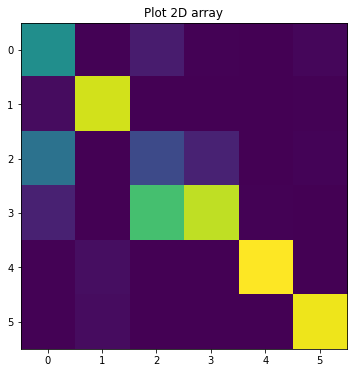

In [21]:
# draw confusion matrix
i = 0
cmatrix = np.zeros((6,6), dtype=np.int16)
for img,lab in test_ds:
#     i = i+1
#     print(i)
    result = model.predict(img, use_multiprocessing=True)
    for j in range(np.size(result,axis=0)):
        id1 = np.argmax(result[j])
        id2 = np.argmax(lab[j])
        # print(id1, id2)
        cmatrix[id1][id2] = cmatrix[id1][id2] + 1
cmatrix = np.absolute(cmatrix)
print(repr(cmatrix))

fig = plt.figure(figsize=(6,6))
plt.imshow(cmatrix)
plt.title("Plot 2D array")
plt.show()